In [1]:
# !pip install celluloid

In [1]:
import numba
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
%matplotlib inline
plt.style.use('dark_background')

In [2]:
# !find / -iname 'libdevice'
# !find / -iname 'libnvvm.so'


In [3]:
# import os
# os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-10.0/nvvm/libdevice"
# os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-10.0/nvvm/lib64/libnvvm.so"

In [2]:
@numba.njit
def krasny_velocity(z1,z0,gamma,delta):
    """
    parameters:
    
    z0 : position of the vortex
    z1 : complex point where velocity is to be calculated
    gamma : strength of the vortex placed at z0
    
    Returns:
    vel : velocity at point z1 due to the vortex placed at z0
    """
    
    dz = z1 - z0
    x = dz.real
    y = dz.imag
    
    phi = (gamma/(2*np.pi*(x*x + y*y + delta*delta)))*(-1j)*dz.conjugate()
    
    u = phi.real
    v = (-1)*phi.imag
    
    return u , v
    

In [3]:
@numba.njit
def chorin_velocity(z1,z0,gamma,delta):
    dz = z1 - z0
    r = np.abs(dz)
    if not r > 1e-7:
        print("z1 = ",z1,"\n\n","z0 = ",z0)
        sys.exit("division by zero ")
        
    if r > delta:
        phi = -1j*dz.conjugate()*gamma/(2*np.pi*r*r)
    else:
        phi = -1j*dz.conjugate()*gamma/(2*np.pi*delta*r)
    
    u = phi.real
    v = -1*phi.imag
    
    return u , v

In [4]:
# ```python

@numba.njit
def krasny_net_velocity(vortex, vortexs, gammas, deltas):
    u = 0.0
    v = 0.0
    curr_idx = np.argmin(np.abs(vortexs - vortex))
    for i,z0 in enumerate(vortexs):
        if curr_idx != i :
            u_temp , v_temp  = krasny_velocity(vortex,z0,gammas[i],deltas[i])
            u = u + u_temp
            v = v + v_temp
    return complex(u , v)

# ```

```python

# @numba.njit
def krasny_net_velocity(vortex, vortexs, gammas, deltas):
    u = 0
    v = 0
    for i,z0 in enumerate(vortexs):
        u_temp , v_temp  = chorin_velocity(vortex,z0,gammas[i],deltas[i])
        u = u + u_temp
        v = v + v_temp
    return complex(u , v)

```

In [5]:
# @numba.njit
def euler_update( x , v , dt):
    return x + v*dt

In [6]:
# @numba.njit
def rk2_update(x,u1,u2,dt):
    return x + (dt/2)*(u1 + u2)

## using the integrator of PR's thesis

```python
@numba.njit
def simulate(vortexs , gammas , deltas , num_iter , dt ):
    num_vortex = len(vortexs)
    path = np.zeros((num_iter,num_vortex),dtype=np.complex128)
    path[0,:] = vortexs.copy()
    cap = 0

    for t in range(num_iter):
        u1 =  np.zeros(num_vortex,dtype=np.complex128)
        u2 = np.zeros(num_vortex,dtype=np.complex128)
        vortex_temp = np.zeros(num_vortex, dtype=np.complex128)
        for i,vortex in enumerate(vortexs):
            u1[i] = krasny_net_velocity(vortex,vortexs,gammas,deltas)
            vortex_temp[i] = vortex + u1[i]*dt/2
            u2[i] = krasny_net_velocity(vortex_temp[i],vortexs,gammas,deltas)
        vortexs = vortex_temp  + u2*dt 
        path[t,:] = vortexs.copy()
        if t%30 == 0 :
            print("Iteration :----------- " , t , "-----------: of :----------" , num_iter , "hang tight")
        # if int(t/num_iter*1000) > cap:
        #   print("% done : --------", t/num_iter*100 , "----------")
        #   cap = cap + 10

    return path
```

In [7]:
# single socastic 

@numba.njit
def simulate(vortexs , gammas , deltas , num_iter , dt ):
    num_vortex = len(vortexs)
    path = np.zeros((num_iter,num_vortex),dtype=np.complex128)
    path[0,:] = vortexs.copy()
    cap = 0

    for t in range(num_iter):
#         u1 =  np.zeros(num_vortex,dtype=np.complex128)
#         u2 = np.zeros(num_vortex,dtype=np.complex128)
#         vortex_temp = np.zeros(num_vortex, dtype=np.complex128)
        for i,vortex in enumerate(vortexs):
            u1 = krasny_net_velocity(vortex,vortexs,gammas,deltas)
            vortex_temp = vortex + u1*dt/2
            u2 = krasny_net_velocity(vortex_temp,vortexs,gammas,deltas)
            vortexs[i] = vortex  + (u2+u1)*dt 
        path[t,:] = vortexs.copy()
        if t%30 == 0 :
            print("Iteration :----------- " , t , "-----------: of :----------" , num_iter , "hang tight")
        # if int(t/num_iter*1000) > cap:
        #   print("% done : --------", t/num_iter*100 , "----------")
        #   cap = cap + 10

    return path

```python

gamma_net = 
J = 24
d = 0.3
M = 10
x_centre = 
y_centre = 
# total number on the circle + 2 on the centre 
num_vortexs = int((M*J*(J+1))/2 + 2)

vortexs = np.zeros(num_vortexs,dtype=np.complex128)

vortexs[:2] = complex(x_centre,y_centre)

idx = 0
for j in range(1,J+1):
    radius_i = j*d
    for i in range(1,j*M + 1):
        theta_ji = i*((2*np.pi)/(j*M))
        x = x_centre + radius_i*np.cos(theta_ji)
        y = y_centre + radius_i*np.sin(theta_ji)
        vortex[idx + 1] = complex(x,y)

```

In [8]:
@numba.njit
def build_plump(x_centre,y_centre,J=24,d=0.3,M=10):
    num_vortexs = int((M*J*(J+1))/2 + 2)
    vortexs = np.zeros(num_vortexs,dtype=np.complex128)
    vortexs[:2] = complex(x_centre,y_centre)
    idx = 1
    for j in range(1,J+1):
        radius_i = j*d
        for i in range(1,j*M + 1):
            theta_ji = i*((2*np.pi)/(j*M))
            x = x_centre + radius_i*np.cos(theta_ji)
            y = y_centre + radius_i*np.sin(theta_ji)
            vortexs[idx + 1] = complex(x,y)
            idx = idx + 1
    return vortexs

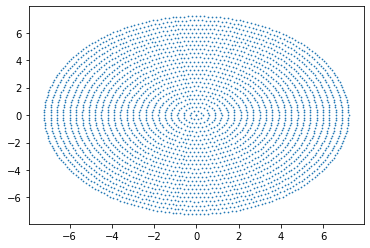

In [31]:
vortex = build_plump(0.0,0.0)
plt.scatter(vortex.real,vortex.imag,s=0.5)

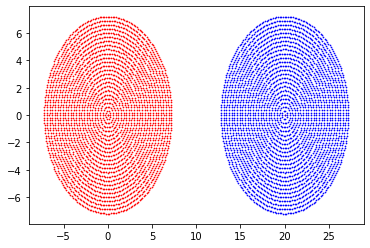

In [32]:
plump_1 = build_plump(0.0,0.0)
plump_2 = build_plump(20.0,0.0)
vortexs = np.concatenate((plump_1,plump_2),axis=0)
plt.scatter(vortexs[:3003].real,vortexs[:3003].imag,color='r',s=0.5)
plt.scatter(vortexs[3003:].real,vortexs[3003:].imag,color='b',s=0.5)

Iteration :-----------  0 -----------: of :---------- 500 hang tight
Iteration :-----------  30 -----------: of :---------- 500 hang tight
Iteration :-----------  60 -----------: of :---------- 500 hang tight
Iteration :-----------  90 -----------: of :---------- 500 hang tight
Iteration :-----------  120 -----------: of :---------- 500 hang tight
Iteration :-----------  150 -----------: of :---------- 500 hang tight
Iteration :-----------  180 -----------: of :---------- 500 hang tight
Iteration :-----------  210 -----------: of :---------- 500 hang tight
Iteration :-----------  240 -----------: of :---------- 500 hang tight
Iteration :-----------  270 -----------: of :---------- 500 hang tight
Iteration :-----------  300 -----------: of :---------- 500 hang tight
Iteration :-----------  330 -----------: of :---------- 500 hang tight
Iteration :-----------  360 -----------: of :---------- 500 hang tight
Iteration :-----------  390 -----------: of :---------- 500 hang tight
Iteration :

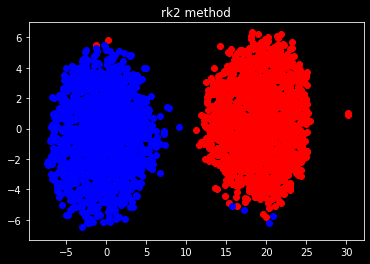

time taken :  244.53048276901245


In [13]:
J = 15 
M = 10

plump_1 = build_plump(0.0,0.0,J=J,d=0.3,M=M)
plump_2 = build_plump(18.5,0.0,J=J,d=0.3,M=M) # 17.2,17.5,17.45
vortexs = np.concatenate((plump_1,plump_2),axis=0)

num_vortexs = int((M*J*(J+1))/2 + 2)


# plt.figure(figsize=(10,10))
# plt.scatter(vortexs[:3003].real,vortexs[:3003].imag,color='r')
# plt.scatter(vortexs[3003:].real,vortexs[3003:].imag,color='b')
# plt.show()


gamma0 = 4*np.pi/0.682
dt = 0.01   #16/3002

t = 5
num_iter = int(t/dt)
# num_iter = 2

gammas = np.ones_like(vortexs,dtype=np.float64)*0.3#*(gamma0/3002)
# print(gammas,gammas.shape)
deltas = np.ones_like(vortexs,dtype=np.float64)*0.05
# print(deltas,deltas.shape)

a = time.time()

plt.figure()
path = simulate(vortexs , gammas , deltas , num_iter , dt)
plt.title("rk2 method")
plt.scatter(path[-1,:num_vortexs + 1].real,path[-1,:num_vortexs + 1].imag,color='r')
plt.scatter(path[-1,num_vortexs + 1:].real,path[-1,num_vortexs + 1:].imag,color='b')
plt.show()

print("time taken : ", time.time() - a)

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(vortexs[:num_vortexs + 1].real,vortexs[:num_vortexs + 1].imag,color='r')
plt.xlim(-5,5)
plt.show()
plt.figure(figsize=(5,5))
plt.scatter(vortexs[num_vortexs + 1:].real,vortexs[num_vortexs + 1:].imag,color='b')
plt.xlim(11,21)
plt.show()

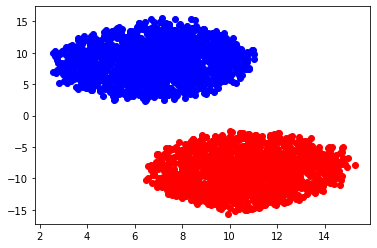

In [34]:
frame = 320

plt.scatter(path[frame,:num_vortexs + 1].real,path[frame,:num_vortexs + 1].imag,color='r')
plt.scatter(path[frame,num_vortexs + 1:].real,path[frame,num_vortexs + 1:].imag,color='b')

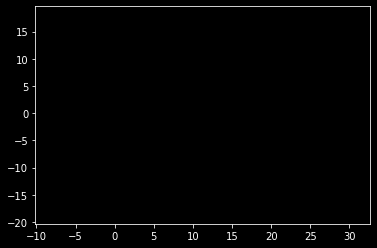

In [14]:
# making animations

fig = plt.figure()
camera = Camera(fig)
plt.style.use('dark_background')
for i in range(int(num_iter)):
    if i%3 == 0 :
        plt.scatter(path[i,:num_vortexs + 1].real,path[i,:num_vortexs + 1].imag,color='r')
        plt.scatter(path[i,num_vortexs + 1:].real,path[i,num_vortexs + 1:].imag,color='b')
        camera.snap()

animation = camera.animate()
from IPython.display import HTML
HTML(animation.to_jshtml())

In [43]:
# animation.save('individual_update.gif')

MovieWriter ffmpeg unavailable; trying to use <class 'matplotlib.animation.PillowWriter'> instead.


Iteration :-----------  0 -----------: of :---------- 500 hang tight
Iteration :-----------  30 -----------: of :---------- 500 hang tight
Iteration :-----------  60 -----------: of :---------- 500 hang tight
Iteration :-----------  90 -----------: of :---------- 500 hang tight
Iteration :-----------  120 -----------: of :---------- 500 hang tight
Iteration :-----------  150 -----------: of :---------- 500 hang tight
Iteration :-----------  180 -----------: of :---------- 500 hang tight
Iteration :-----------  210 -----------: of :---------- 500 hang tight
Iteration :-----------  240 -----------: of :---------- 500 hang tight
Iteration :-----------  270 -----------: of :---------- 500 hang tight
Iteration :-----------  300 -----------: of :---------- 500 hang tight
Iteration :-----------  330 -----------: of :---------- 500 hang tight
Iteration :-----------  360 -----------: of :---------- 500 hang tight
Iteration :-----------  390 -----------: of :---------- 500 hang tight
Iteration :

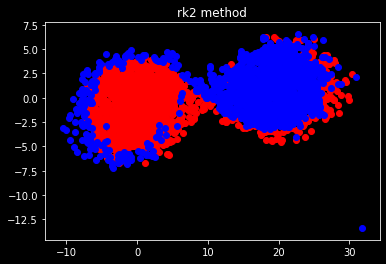

time taken :  275.7011203765869


In [15]:
a = time.time()

plt.figure()
path1 = simulate(path[-1,:] , gammas , deltas , num_iter , dt)
plt.title("rk2 method")
plt.scatter(path1[-1,:num_vortexs + 1].real,path1[-1,:num_vortexs + 1].imag,color='r')
plt.scatter(path1[-1,num_vortexs + 1:].real,path1[-1,num_vortexs + 1:].imag,color='b')
plt.show()

print("time taken : ", time.time() - a)

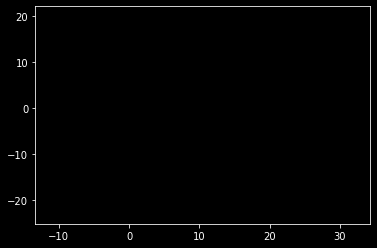

In [16]:
# making animations

fig = plt.figure()
camera = Camera(fig)

for i in range(num_iter):
    if i%3 == 0:
        plt.scatter(path1[i,:num_vortexs + 1].real,path1[i,:num_vortexs + 1].imag,color='r')
        plt.scatter(path1[i,num_vortexs + 1:].real,path1[i,num_vortexs + 1:].imag,color='b')
        camera.snap()

animation = camera.animate()
from IPython.display import HTML
HTML(animation.to_jshtml())

In [ ]:
t = 10
num_iter = int(t/dt)

a = time.time()

plt.figure()
path2 = simulate(path1[-1,:] , gammas , deltas , num_iter , dt)
plt.title("rk2 method")
plt.scatter(path2[-1,:num_vortexs + 1].real,path2[-1,:num_vortexs + 1].imag,color='r')
plt.scatter(path2[-1,num_vortexs + 1:].real,path2[-1,num_vortexs + 1:].imag,color='b')
plt.show()

print("time taken : ", time.time() - a)

In [ ]:
# making animations

fig = plt.figure()
camera = Camera(fig)

for i in range(num_iter):
    if i%30 == 0:
        plt.scatter(path2[i,:num_vortexs + 1].real,path2[i,:num_vortexs + 1].imag,color='r')
        plt.scatter(path2[i,num_vortexs + 1:].real,path2[i,num_vortexs + 1:].imag,color='b')
        camera.snap()

animation = camera.animate()
from IPython.display import HTML
HTML(animation.to_jshtml())

In [ ]:
t = 10
num_iter = int(t/dt)

a = time.time()

plt.figure()
path3 = simulate(path[-1,:] , gammas , deltas , num_iter , dt)
plt.title("rk2 method")
plt.scatter(path3[-1,:num_vortexs + 1].real,path3[-1,:num_vortexs + 1].imag,color='r')
plt.scatter(path3[-1,num_vortexs + 1:].real,path3[-1,num_vortexs + 1:].imag,color='b')
plt.show()

print("time taken : ", time.time() - a)

In [ ]:
# making animations

fig = plt.figure()
camera = Camera(fig)

for i in range(num_iter):
    if i%30 == 0:
        plt.scatter(path3[i,:num_vortexs + 1].real,path3[i,:num_vortexs + 1].imag,color='r')
        plt.scatter(path3[i,num_vortexs + 1:].real,path3[i,num_vortexs + 1:].imag,color='b')
        camera.snap()

animation = camera.animate()
from IPython.display import HTML
HTML(animation.to_jshtml())